## Surface

With the Surface tools, you can quantify and visualize a terrain landform represented by a digital elevation model.

Starting with a raster elevation surface that represented as an Xarray DataArray (or an Xarray Dataset containing multiple elevation variables), these tools help you in identifying some specific patterns that were not readily apparent in the original surface. When a DataArray is passed, the return is a DataArray. When a Dataset is passed, the function is applied to each variable independently and the return is a Dataset.

- [Hillshade](#Hillshade): Creates a shaded relief from a surface raster by considering the illumination source angle and shadows.
- [Slope](#Slope): Identifies the slope from each cell of a raster.
- [Curvature](#Curvature): Calculates the curvature of a raster surface.
- [Aspect](#Aspect): Derives the aspect from each cell of a raster surface.
- [Viewshed](#Viewshed): Determines visible locations in the input raster surface from a viewpoint with some optional observer features.

### Importing Packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import datashader as ds

from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation

import xrspatial

### Generate Terrain Data

The rest of the geo-related functions focus on raster data, i.e. data that's been aggregated into the row-column grid of cells in a raster image. Datashader's Canvas object provides a convenient frame to set up a new raster, so we'll use that with our `generate_terrain` function to generate some fake terrain as an elevation raster. Once we have that, we'll use datashader's shade for easy visualization.

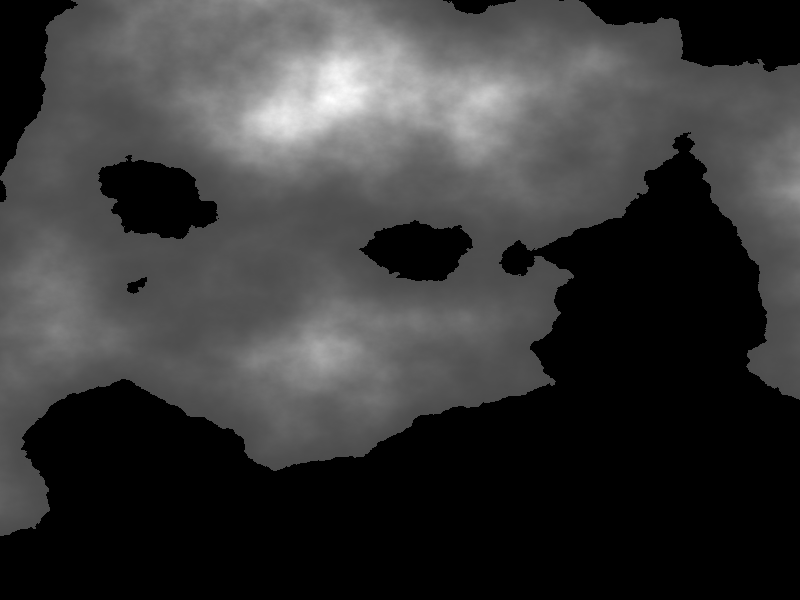

In [2]:
from xrspatial import generate_terrain

W = 800
H = 600

terrain = xr.DataArray(np.zeros((H, W)))
terrain = generate_terrain(terrain)

shade(terrain, cmap=["black", "white"], how="linear")

The grayscale values in the image above show elevation, scaled linearly in black-to-white color intensity (with the large black areas indicating low elevation). This shows the data, but it would look more like a landscape if we map the lowest values to colors representing water, and the highest to colors representing mountaintops. Let's try the Elevation colormap we imported above:

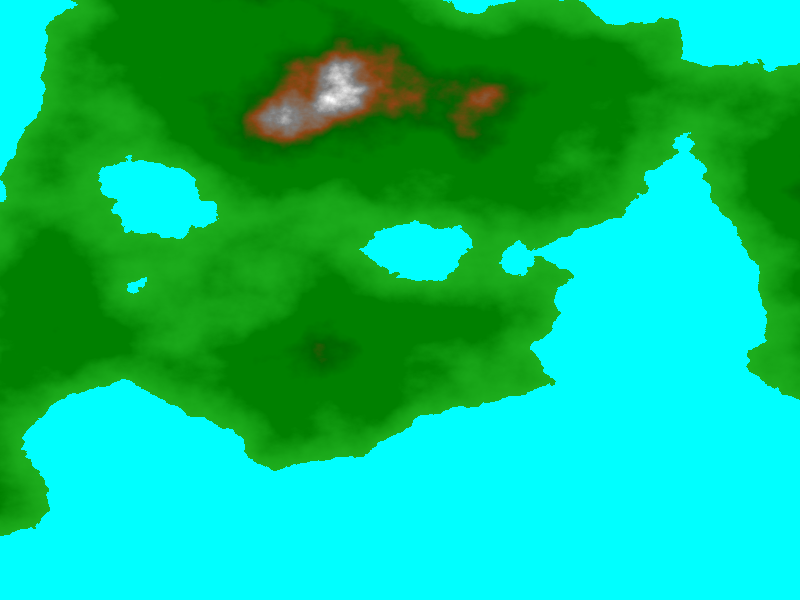

In [3]:
shade(terrain, cmap=Elevation, how="linear")

### Hillshade

[Hillshade](https://en.wikipedia.org/wiki/Terrain_cartography) is a technique used to visualize terrain as shaded relief by illuminating it with a hypothetical light source. The illumination value for each cell is determined by its orientation to the light source, which can be calculated from slope and aspect.

Let's apply Hillshade to our terrain and visualize the result with shade.

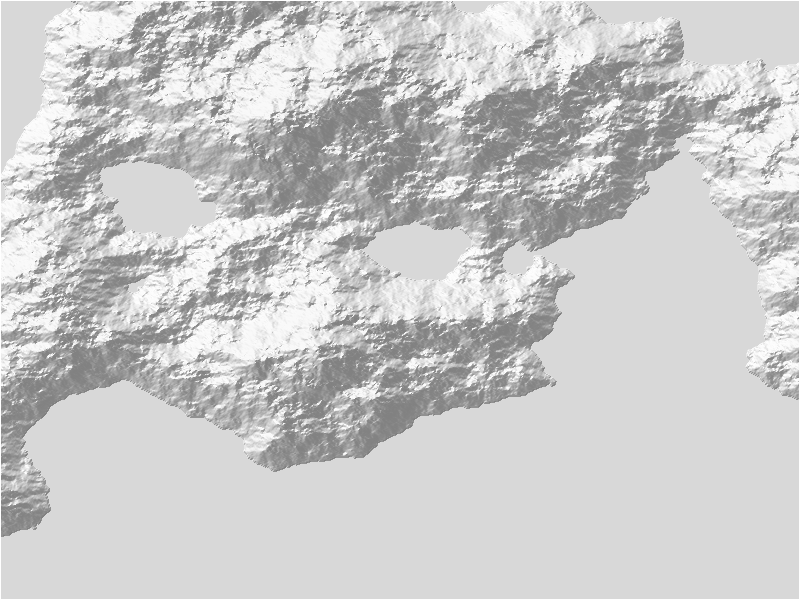

In [4]:
from xrspatial import hillshade

illuminated = hillshade(terrain)

hillshade_gray_white = shade(
    illuminated, cmap=["gray", "white"], alpha=255, how="linear"
)
hillshade_gray_white

Applying hillshade reveals a lot of detail in the 3D shape of the terrain.

To add even more detail, we can add the Elevation colormapped terrain from earlier and combine it with the hillshade terrain using datashader's stack function.

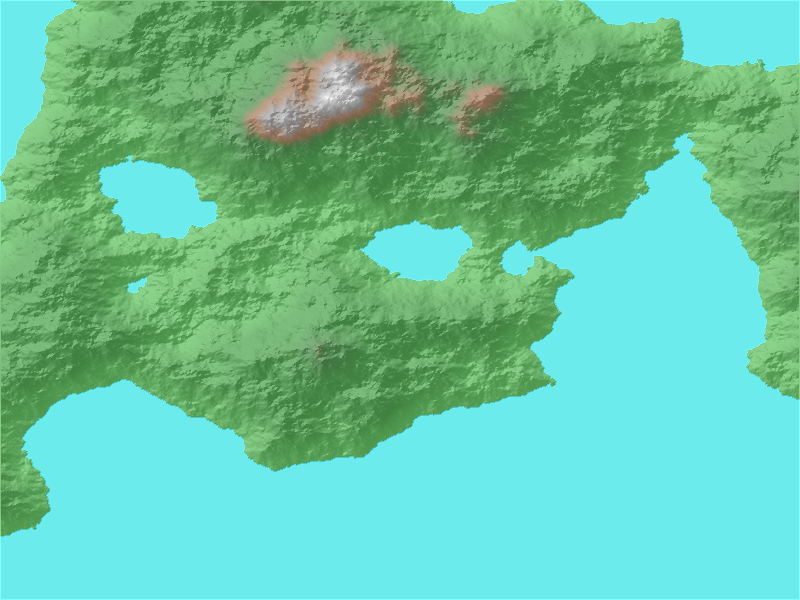

In [5]:
terrain_elevation = shade(terrain, cmap=Elevation, alpha=128, how="linear")
stack(hillshade_gray_white, terrain_elevation)

### Slope

[Slope](https://en.wikipedia.org/wiki/Slope) is the inclination of a surface. 
In geography, *slope* is the amount of change in elevation for an area in a terrain relative to its surroundings.

Xarray-spatial's slope function returns the slope at each cell in degrees.
Because Xarray-spatial is integrated with Xarray and Numpy, we can apply standard Numpy filters. For example, we can highlight only slopes in the [avalanche risk](http://wenatcheeoutdoors.org/2016/04/07/avalanche-abcs-for-snowshoers/) range of 25 - 50 degrees. (Note the use of risky.data since these are DataArrays).
Stacking the resulting raster with the hillshaded and plain terrain ones from above gives an image with areas of avalanche risk neatly highlighted.

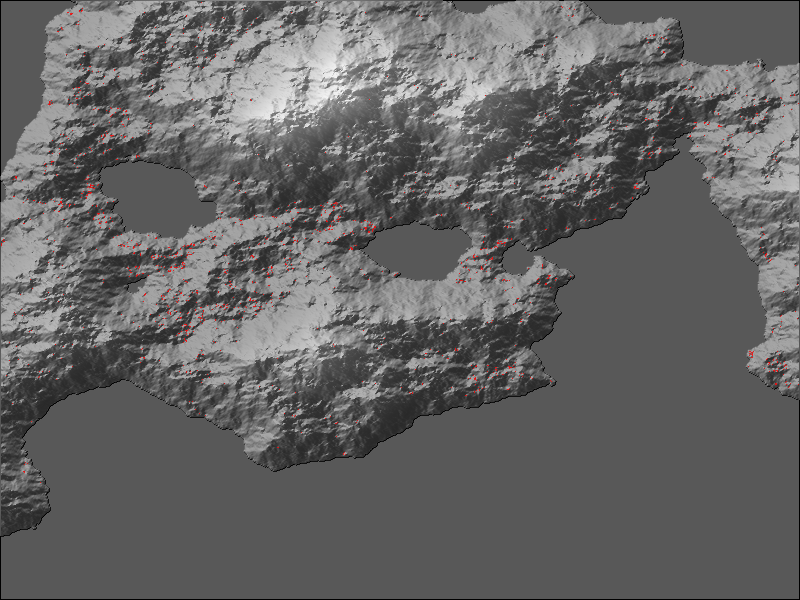

In [6]:
from xrspatial import slope

risky = slope(terrain)
risky.data = np.where(np.logical_and(risky.data > 25, risky.data < 50), 1, np.nan)

stack(
    shade(terrain, cmap=["black", "white"], how="linear"),
    shade(illuminated, cmap=["black", "white"], how="linear", alpha=128),
    shade(risky, cmap="red", how="linear", alpha=200),
)

### Curvature

[Curvature](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/curvature.htm) is the second derivative of a surface's elevation, or the *slope-of-the-slope*; in other words, how fast the slope is increasing or decreasing as we move along a surface.
- A positive curvature means the surface is curving up (upwardly convex) at that cell. 
- A negative curvature means the surface is curving down (downwardly convex) at that cell. 
- A curvature of 0 means the surface is striaght and constant in whatever angle it's sloped towards.

The Xarray-spatial curvature function returns a raster in units one hundredth (1/100) of the z-factor, or scaling factor (which you can set explicitly in generate _terrain as "zfactor").  
Reasonably expected values in the curvature raster for a hilly area (moderate relief) would be between -0.5 and 0.5, while for steep, rugged mountains (extreme relief) these can range as far as -4 and 4. For certain raster surfaces it is possible to go even larger than that.

Let's generate a terrain with an appropriate z-factor and apply the curvature function to it. Then, we can apply some Numpy filtering (remember, we have access to all those functions) to highlight steeper and gentler curves in the slopes.
Stacking these with the hillshaded and plain terrains gives us a fuller picture of the slopes.

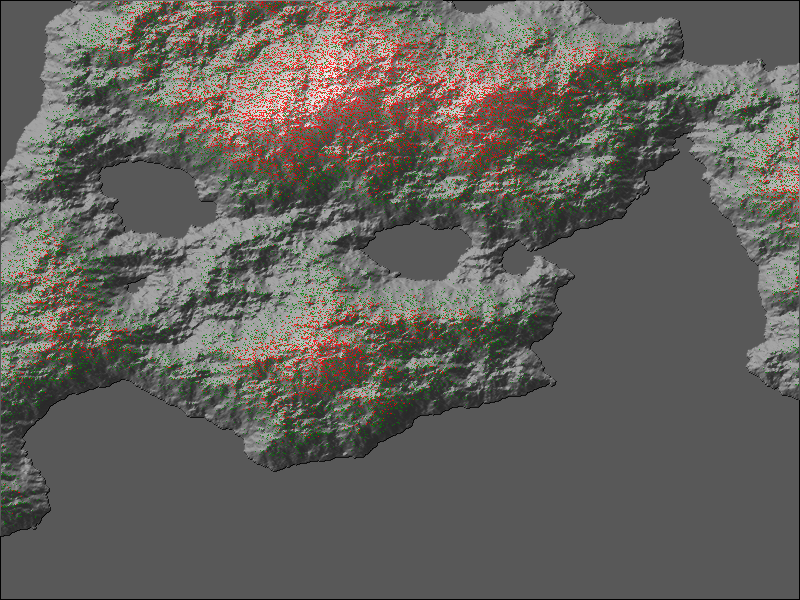

In [7]:
from xrspatial import curvature

terrain_z_one = xr.DataArray(np.zeros((H, W)))
terrain_z_one = generate_terrain(terrain_z_one, zfactor=1)
curv = curvature(terrain_z_one)
curv_hi, curv_low = curv.copy(), curv.copy()
curv_hi.data = np.where(np.logical_and(curv_hi.data > 1, curv_hi.data < 4), 1, np.nan)
curv_low.data = np.where(
    np.logical_and(curv_low.data > 0.5, curv_low.data < 1), 1, np.nan
)

stack(
    shade(terrain, cmap=["black", "white"], how="linear"),
    shade(illuminated, cmap=["black", "white"], how="linear", alpha=128),
    shade(curv_hi, cmap="red", how="log", alpha=200),
    shade(curv_low, cmap="green", how="log", alpha=200),
)

### Aspect

[Aspect](https://en.wikipedia.org/wiki/Aspect_(geography)) is the orientation of a slope, measured clockwise in degrees from 0 to 360, where 0 is north-facing, 90 is east-facing, 180 is south-facing, and 270 is west-facing.

The Xarray-spatial aspect function returns the aspect in degrees for each cell in an elevation terrain.

We can apply aspect to our terrain, then use Numpy to filter out only slopes facing close to North. Then, we can stack that with the hillshaded and plain terrains.
(Note: the printout images are from a North point-of-view.)

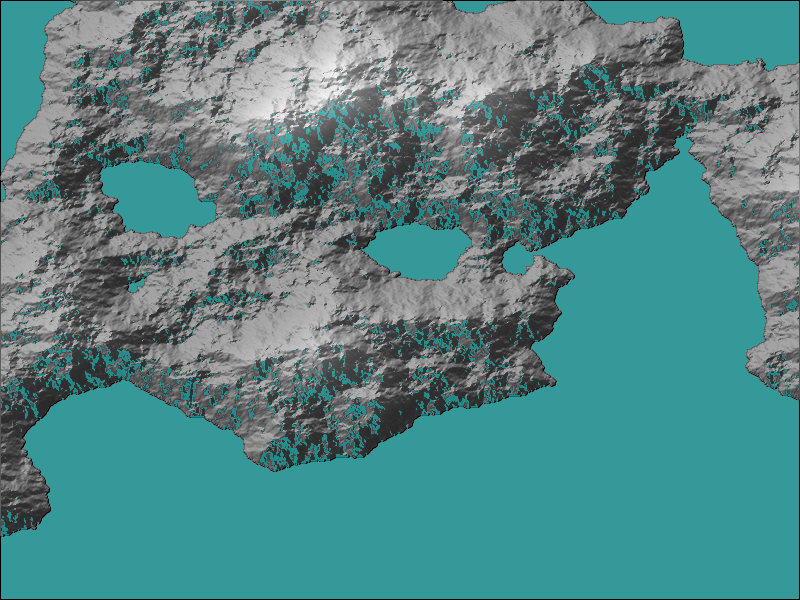

In [8]:
from xrspatial import aspect

north_faces = aspect(terrain)
north_faces.data = np.where(
    np.logical_or(north_faces.data > 350, north_faces.data < 10), 1, np.nan
)

stack(
    shade(terrain, cmap=["black", "white"], how="linear"),
    shade(illuminated, cmap=["black", "white"], how="linear", alpha=128),
    shade(north_faces, cmap=["aqua"], how="linear", alpha=100),
)

### Viewshed

The `xrspatial.viewshed` function operates on a given aggregate to calculate the viewshed (the visible cells in the raster) for a given viewpoint, or *observer location*.  

The visibility model is as follows: Two cells are visible to each other if the line of sight that connects their centers is not blocked at any point by another part of the terrain. If the line of sight does not pass through the cell center, elevation is determined using bilinear interpolation.

#### Simple Viewshed Example

- The example below creates a datashader aggregate from a 2d normal distribution.
- To calculate the viewshed, we need an observer location so we'll set up an aggregate for that as well.
- Then, we can visualize all of that with hillshade, shade, and stack.
- The observer location is indicated by the orange point in the upper-left of the plot.

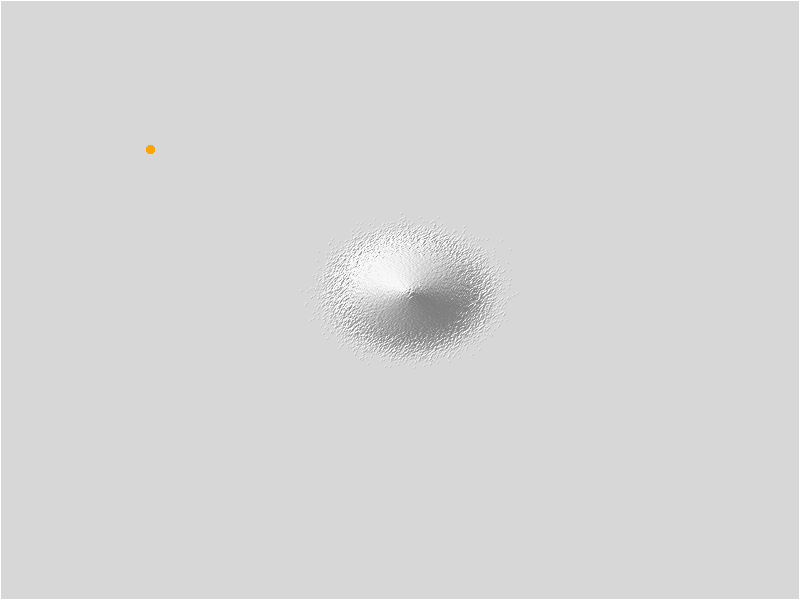

In [9]:
from xrspatial import viewshed

OBSERVER_X = -12.5
OBSERVER_Y = 10

canvas = ds.Canvas(plot_width=W, plot_height=H, x_range=(-20, 20), y_range=(-20, 20))

normal_df = pd.DataFrame(
    {"x": np.random.normal(0.5, 1, 10000000), "y": np.random.normal(0.5, 1, 10000000)}
)
normal_agg = canvas.points(normal_df, "x", "y")
normal_agg.values = normal_agg.values.astype("float64")
normal_shaded = shade(normal_agg)

observer_df = pd.DataFrame({"x": [OBSERVER_X], "y": [OBSERVER_Y]})
observer_agg = canvas.points(observer_df, "x", "y")
observer_shaded = dynspread(shade(observer_agg, cmap=["orange"]), threshold=1, max_px=4)

normal_illuminated = hillshade(normal_agg)
normal_illuminated_shaded = shade(
    normal_illuminated, cmap=["black", "white"], alpha=128, how="linear"
)

stack(normal_illuminated_shaded, observer_shaded)

#### Calculate viewshed using the observer location

Now we can apply viewshed to the normal_agg, with the observer_agg for the viewpoint. We can then visualize it and stack it with the hillshade and observer rasters.

CPU times: user 5.81 s, sys: 475 ms, total: 6.29 s
Wall time: 6.45 s


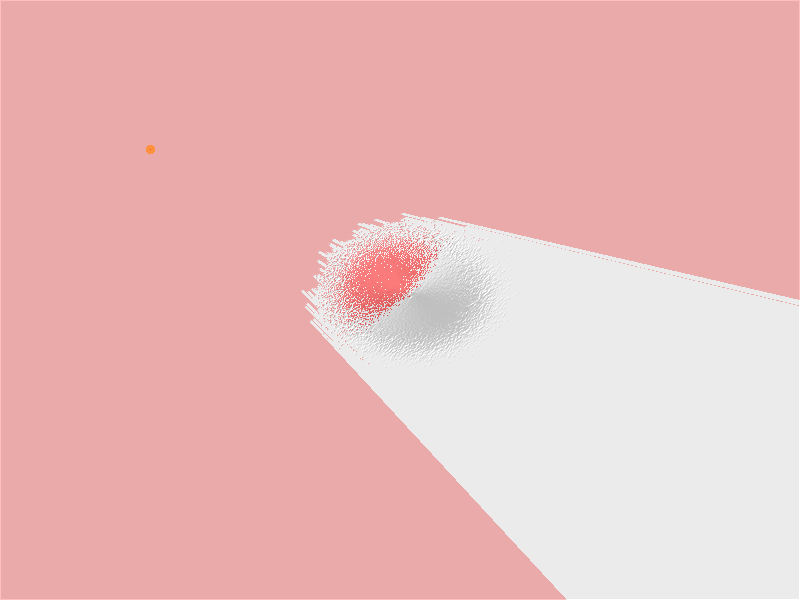

In [10]:
# Will take some time to run...
%time view = viewshed(normal_agg, x=OBSERVER_X, y=OBSERVER_Y)

view_shaded = shade(view, cmap=["white", "red"], alpha=128, how="linear")

stack(normal_illuminated_shaded, observer_shaded, view_shaded)

As you can see, the image highlights in red all points visible from the observer location marked with the orange dot. As one might expect, the areas behind the normal distribution *mountain* are blocked from the viewer.

#### Viewshed on Terrain

Now we can try using viewshed on our more complicated terrain.

- We'll set up our terrain aggregate and apply hillshade and shade for easy visualization.
- We'll also set up an observer location aggregate, setting the location to the center, at (x, y) = (0, 0).

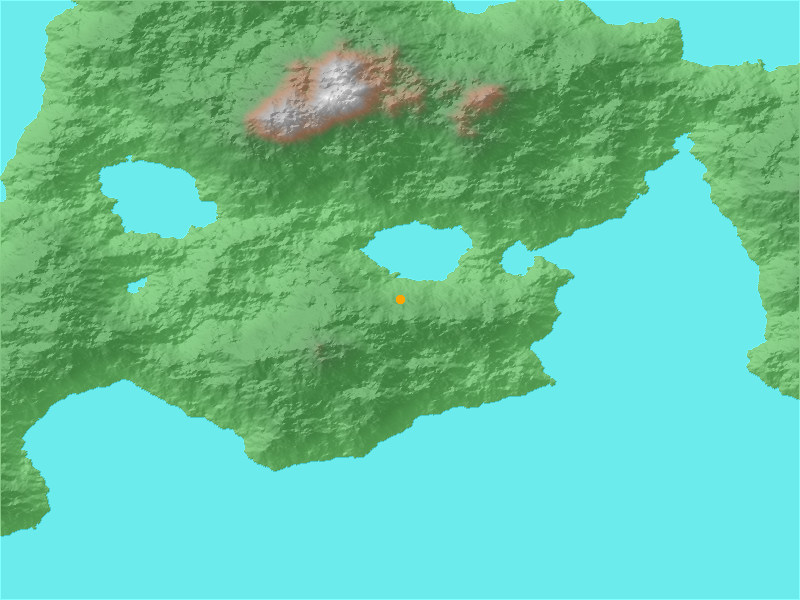

In [11]:
from xrspatial import viewshed

x_range = (-20e6, 20e6)
y_range = (-20e6, 20e6)
terrain = xr.DataArray(np.zeros((H, W)))
terrain = generate_terrain(terrain, x_range=x_range, y_range=y_range)
terrain_shaded = shade(terrain, cmap=Elevation, alpha=128, how="linear")

illuminated = hillshade(terrain)

OBSERVER_X = 0.0
OBSERVER_Y = 0.0

cvs = ds.Canvas(plot_width=W, plot_height=H, x_range=x_range, y_range=y_range)
observer_df = pd.DataFrame({"x": [OBSERVER_X], "y": [OBSERVER_Y]})
observer_agg = cvs.points(observer_df, "x", "y")
observer_shaded = dynspread(shade(observer_agg, cmap=["orange"]), threshold=1, max_px=4)

stack(
    shade(illuminated, cmap=["black", "white"], alpha=128, how="linear"),
    terrain_shaded,
    observer_shaded,
)

Now we can apply viewshed.
- Notice the use of the `observer_elev` argument, which is the height of the observer above the terrain.

CPU times: user 361 ms, sys: 98.1 ms, total: 459 ms
Wall time: 468 ms


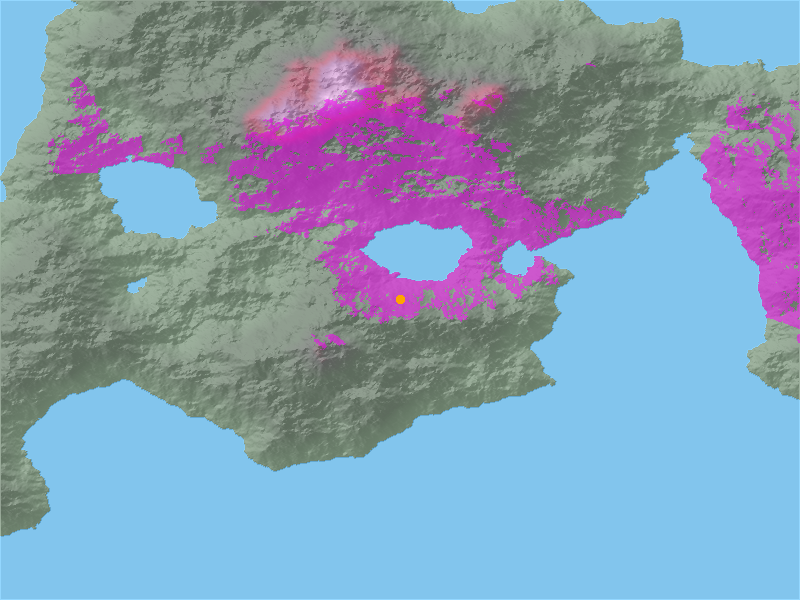

In [12]:
%time view = viewshed(terrain, x=OBSERVER_X, y=OBSERVER_Y, observer_elev=100)

view_shaded = shade(view, cmap="fuchsia", how="linear")
stack(
    shade(illuminated, cmap=["black", "white"], alpha=128, how="linear"),
    terrain_shaded,
    view_shaded,
    observer_shaded,
)

The fuchsia areas are those visible to an observer of the given height at the indicated orange location.

### References

- An overview of the Surface toolset: https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/an-overview-of-the-surface-tools.htm
- Burrough, P. A., and McDonell, R. A., 1998. Principles of Geographical Information Systems (Oxford University Press, New York), p. 406.
- Making Maps with Noise Functions: https://www.redblobgames.com/maps/terrain-from-noise/
- How Aspect Works: http://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/how-aspect-works.htm#ESRI_SECTION1_4198691F8852475A9F4BC71246579FAA